<a href="https://colab.research.google.com/github/Kalkidan-Gashaw/Convex_Optimization_in_AI/blob/main/Convex_Optimization_in_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convex Optimization in Artificial Intelligence

Optimization plays a central role in AI, as many algorithms aim to minimize a loss function subject to constraints. Convex optimization is especially important because it guarantees convergence to a **global optimum**, making AI models more reliable and efficient.

In this notebook, we will explore:
- The basic concepts of convex optimization.
- How duality simplifies constrained optimization.
- A practical example using Support Vector Machines (SVMs) to demonstrate convex optimization in AI.
- Comparison of a custom SVM implementation with scikit-learn’s SVM.


## Convex Optimization Problem Setup

A **convex optimization problem** is an optimization problem where the objective function and the feasible set (defined by the constraints) are convex. This guarantees that any **local minimum is also a global minimum**.

### General Form

A convex optimization problem can be written as:

$$
\text{minimize } f(x) \\
\text{subject to } g_i(x) \leq 0, \quad h_j(x) = 0
$$

where:
- $f(x)$ is a **convex function** (objective function)
- $g_i(x)$ are **convex inequality constraints**
- $h_j(x)$ are **affine equality constraints**

### Why Convexity Matters

- Ensures a **unique global optimum**.
- Allows the use of **efficient polynomial-time algorithms**.
- Common in AI applications like:
  - Support Vector Machines (SVMs)
  - Logistic Regression
  - Portfolio Optimization


## Duality Concept

Duality is an important concept in convex optimization that helps simplify constrained problems and improve computational efficiency.

### Primal and Dual Problems

- The **primal problem** is the original optimization problem:

$$
\text{minimize } f(x) \quad \text{subject to } g_i(x) \le 0, \; h_j(x) = 0
$$

- By introducing **Lagrange multipliers** $\lambda_i \ge 0$ for inequalities and $\nu_j$ for equalities, we can form the **Lagrangian**:

$$
\mathcal{L}(x, \lambda, \nu) = f(x) + \sum_i \lambda_i g_i(x) + \sum_j \nu_j h_j(x)
$$

- The **dual problem** is then:

$$
\text{maximize } \inf_x \mathcal{L}(x, \lambda, \nu) \quad \text{subject to } \lambda_i \ge 0
$$

### Why Duality Matters

1. **Simplifies computation**: Sometimes the dual problem is easier to solve than the primal.  
2. **Provides bounds**: The solution of the dual gives a lower bound (for minimization problems) on the primal objective.  
3. **Insight into constraints**: Lagrange multipliers show how sensitive the optimal value is to the constraints.  

### Example in AI: SVM

- In Support Vector Machines, the **dual formulation** allows using kernels and reduces the problem to optimizing over Lagrange multipliers instead of the weight vector \(w\).  
- The dual is always a **convex problem** if the primal is convex, ensuring a global optimum.


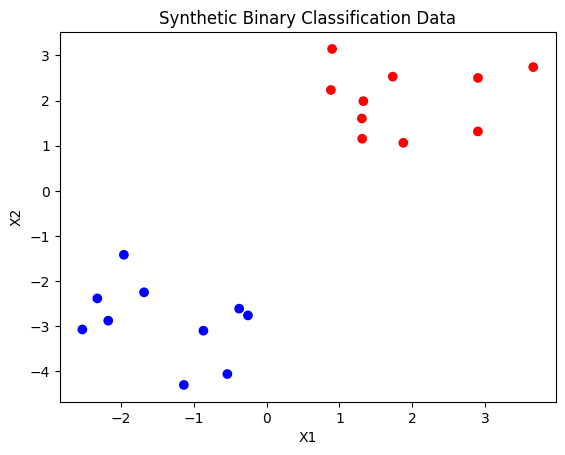

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(1)

# Generate synthetic 2D data for two classes
X_class1 = np.random.randn(10, 2) - [2, 2]   # Class -1
X_class2 = np.random.randn(10, 2) + [2, 2]   # Class +1

# Combine data points
X = np.vstack((X_class1, X_class2))
y = np.hstack((-1 * np.ones(10), np.ones(10)))  # Labels: -1 and +1

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.title("Synthetic Binary Classification Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [3]:
# Import cvxopt for quadratic programming
from cvxopt import matrix, solvers

# Compute the linear kernel matrix K = X*X^T
K = np.dot(X, X.T)
n_samples = X.shape[0]

# Setup matrices for cvxopt QP solver
P = matrix(np.outer(y, y) * K)     # Quadratic term (Hessian)
q = matrix(-np.ones(n_samples))     # Linear term
G = matrix(-np.eye(n_samples))      # Inequality constraint Gx <= h (alpha_i >= 0)
h = matrix(np.zeros(n_samples))
A = matrix(y, (1, n_samples))       # Equality constraint sum(alpha_i * y_i) = 0
b = matrix(0.0)

# Solve QP problem
solvers.options['show_progress'] = False  # Disable solver output
solution = solvers.qp(P, q, G, h, A, b)

# Extract Lagrange multipliers
alphas = np.ravel(solution['x'])

# Identify support vectors (alpha > 1e-5)
sv = alphas > 1e-5
X_sv = X[sv]
y_sv = y[sv]
alphas_sv = alphas[sv]

print(f"Number of support vectors: {len(X_sv)}")


Number of support vectors: 3


Weight vector w: [0.29953423 0.39671333]
Bias b: 0.14864036085347102


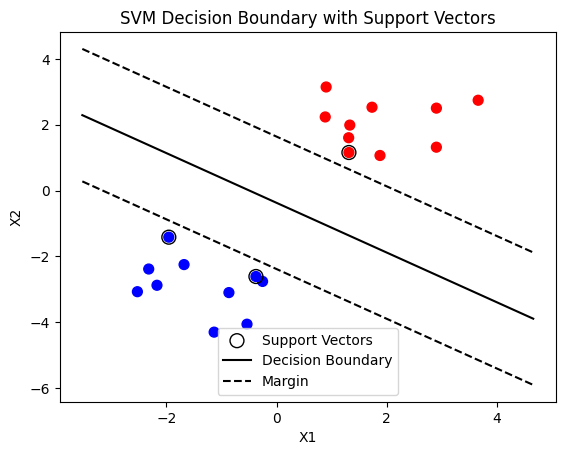

In [4]:
# Compute weight vector w for linear SVM
w = np.sum(alphas_sv[:, None] * y_sv[:, None] * X_sv, axis=0)

# Compute bias b using support vectors
b = np.mean(y_sv - np.dot(X_sv, w))

print(f"Weight vector w: {w}")
print(f"Bias b: {b}")

# Plot decision boundary and margins
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=50)
plt.scatter(X_sv[:, 0], X_sv[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

# Create a grid of points to plot the decision boundary
x_plot = np.linspace(min(X[:,0])-1, max(X[:,0])+1, 200)
y_plot = (-w[0] * x_plot - b) / w[1]

# Plot decision boundary
plt.plot(x_plot, y_plot, 'k-', label='Decision Boundary')

# Plot margins
margin = 1 / np.linalg.norm(w)
plt.plot(x_plot, y_plot + margin, 'k--', label='Margin')
plt.plot(x_plot, y_plot - margin, 'k--')

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("SVM Decision Boundary with Support Vectors")
plt.legend()
plt.show()


sklearn weight vector: [[0.29945288 0.39660566]]
sklearn bias: [0.14850953]
Number of support vectors (sklearn): 3


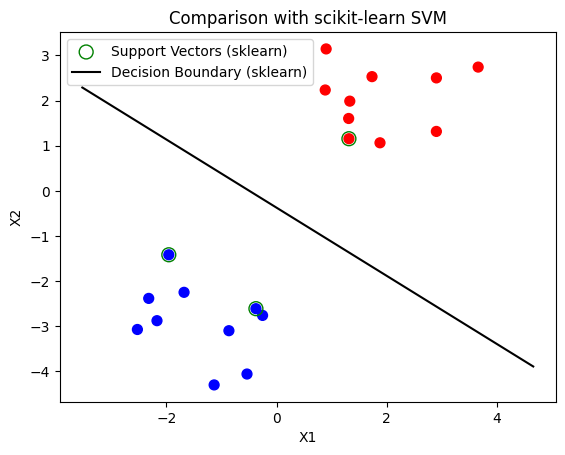

In [5]:
# Import scikit-learn SVM
from sklearn.svm import SVC

# Train linear SVM using scikit-learn
clf = SVC(kernel='linear', C=1e6)  # Large C for hard-margin SVM
clf.fit(X, y)

# Print sklearn SVM parameters
print(f"sklearn weight vector: {clf.coef_}")
print(f"sklearn bias: {clf.intercept_}")
print(f"Number of support vectors (sklearn): {len(clf.support_)}")

# Plot scikit-learn SVM decision boundary and support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=50)
plt.scatter(X[clf.support_, 0], X[clf.support_, 1], s=100, facecolors='none', edgecolors='g', label='Support Vectors (sklearn)')

# Decision boundary
x_plot = np.linspace(min(X[:,0])-1, max(X[:,0])+1, 200)
y_plot = (-clf.coef_[0,0] * x_plot - clf.intercept_[0]) / clf.coef_[0,1]
plt.plot(x_plot, y_plot, 'k-', label='Decision Boundary (sklearn)')

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Comparison with scikit-learn SVM")
plt.legend()
plt.show()


## Conclusion and Insights

In this notebook, we explored **convex optimization** and its role in **artificial intelligence**, using Support Vector Machines (SVMs) as a practical example.

### Key Takeaways

1. **Convex Optimization Guarantees Global Optimum**
   - Because the objective function and feasible set are convex, any local minimum is also the global minimum.
   - This ensures reliable solutions for AI models like SVMs and logistic regression.

2. **Duality Simplifies Constrained Problems**
   - By introducing Lagrange multipliers, we transformed the constrained primal problem into the dual problem.
   - Solving the dual can be computationally more efficient and provides insights into which constraints are active.

3. **SVM Implementation**
   - We implemented a **custom linear SVM** by solving the dual problem using `cvxopt`.
   - Computed the **weight vector, bias, decision boundary, and support vectors**.
   - Compared the results with **scikit-learn’s SVC**, confirming that convex optimization produces the same optimal solution.

4. **Practical Insights**
   - Convex optimization is widely used in AI to train models efficiently.
   - Dual formulations, kernels, and support vectors are all practical tools derived from convex optimization theory.

> Overall, convex optimization provides both **theoretical guarantees** and **practical efficiency**, making it a cornerstone in machine learning and AI model design.
